Projeto


In [ ]:
#!pip install SoccerNet --upgrade
#!pip install transformers
#!pip install ffmpeg
#!pip install torch
#!pip install ffmpeg-python
#!pip install accelerate
#!pip instal scikit-learn
#!pip install matplotlib

### Mount drive


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


### Import dataset from SoccerNet


In [ ]:
from SoccerNet.Downloader import SoccerNetDownloader

password = "s0cc3rn3t"

def unlabeled_dataset(LocalDirectory):
    myDownloader = SoccerNetDownloader(LocalDirectory=LocalDirectory)
    myDownloader.password = password
    myDownloader.downloadGames(files=["1_224p.mkv", "2_224p.mkv"], split=["train","valid","test","challenge"])

def labeled_dataset(LocalDirectory):
    myDownloader = SoccerNetDownloader(LocalDirectory="Football-Dataset/")
    myDownloader.password = password
    myDownloader.downloadGames(files=["Labels-v2.json"], split=["train","valid","test"])

#unlabeled_dataset("Football-Dataset/")
labeled_dataset("Football-Dataset/")

### Import dependencies


In [1]:
import ffmpeg
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
import torch
import os
import shutil
import time
import pandas as pd
import numpy as np
import json

/home/simao/.conda/envs/projeto/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Building our model


In [17]:
def build_model(model_id):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32


    model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, use_safetensors=True
                                                      )
    model.to(device)

    processor = AutoProcessor.from_pretrained(model_id, language="en")

    pipe = pipeline(
        "automatic-speech-recognition",
        model=model,
        tokenizer=processor.tokenizer,
        feature_extractor=processor.feature_extractor,
        max_new_tokens=128,
        chunk_length_s=30,
        batch_size=16,
        return_timestamps=True,
        torch_dtype=torch_dtype,
        device=device,
    )

    return pipe

model_id = "openai/whisper-base" #"openai/whisper-large-v3"
model_ids = ["openai/whisper-base", "openai/whisper-small", "openai/whisper-medium", "openai/whisper-large"]
pipe = build_model(model_id=model_id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Fragment audio and translate


In [30]:
# environment variables
#local_dir = "drive/MyDrive/DTX/Football-Dataset"
dir = "Football-Dataset/england_epl/"

def update_txt_file(text, path):
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)


def audio_to_text(pipe, model_id):
  for year in os.listdir(dir):
      games = os.path.join(dir, year)
      for game in os.listdir(games):
          if game != ".ipynb_checkpoints":
              game_dir = os.path.join(games, game)
              frag1_dir = os.path.join(game_dir, "fragments_1_224p")
              frag2_dir = os.path.join(game_dir, "fragments_2_224p")

              for audioFrag1 in os.listdir(frag1_dir):
                result = pipe(frag1_dir + '/' + audioFrag1, return_timestamps=True,  generate_kwargs = {"language": "english", "task": "translate"})
                update_txt_file(result['text'], frag1_dir + f'/{audioFrag1[:-4]}__{model_id[7:]}.txt')

              for audioFrag2 in os.listdir(frag2_dir):
                result = pipe(frag2_dir + '/' + audioFrag2, return_timestamps=True,  generate_kwargs = {"language": "english", "task": "translate"})
                update_txt_file(result['text'], frag2_dir + f'/{audioFrag2[:-4]}__{model_id[7:]}.txt')


def clear_nonvideos(path):
    for t in os.listdir(path):
        if os.path.isdir(path + '/' + t):
          shutil.rmtree(path + '/' + t)
        else:
          if not t.endswith(".mkv"):
             os.remove(path + '/' + t)


def fragment_dataset_audio(audio_cut_length, offset):
  for year in os.listdir(dir):
      games = os.path.join(dir, year)
      for game in os.listdir(games):
          game_dir = os.path.join(games, game)

          if game != ".ipynb_checkpoints":
            clear_nonvideos(game_dir)
            for videoFile in os.listdir(game_dir):
                pathVideo = game_dir + "/" + videoFile
                videoFragments = game_dir + f"/fragments_{videoFile[:-4]}"
                
                # este if não está a funcionar como é suposto
                if not os.path.exists(videoFragments):
                  print("Criei pasta: ", videoFragments)
                  os.mkdir(videoFragments)

                duration = float(ffmpeg.probe(pathVideo)["format"]["duration"])
                steps = duration/audio_cut_length
                for n in range(int(steps)+1):
                  try:
                    ffmpeg.input(pathVideo, ss=(n*audio_cut_length)-offset, to=(n+1)*audio_cut_length).output(videoFragments + f"/fragment_{n}.wav").run(quiet=True, overwrite_output=True)
                  except ffmpeg.Error as e:
                    print("Output: ", e.stdout)
                    print("Error: ", e.stderr)

#fragment_dataset_audio(audio_cut_length=30, offset=2)
audio_to_text(pipe=pipe, model_id=model_id)

Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the m

### Benchmark


In [35]:

def get_fragment_zero(m):
   with open(dir+f"2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/fragments_1_224p/fragment_0__{m[7:]}.txt", "r") as f:
      return f.readline()


def benchmark():
  for m in model_ids:
    fragment_dataset_audio(audio_cut_length=30, offset=2)
    start_time = time.time()
    pipe = build_model(model_id=m)
    audio_to_text(pipe, m)
    print(f"Model: {m}")
    print(f"Time (seconds): {time.time() - start_time}")
    frag0 = get_fragment_zero(m)
    print(f"Fragment 0: {frag0}")


def benchmark_json():
    benchmarks_times = {"openai/whisper-tiny": "7:52", "openai/whisper-base": "13:34", "openai/whisper-small": "34:52", "openai/whisper-medium": "85:36", "openai/whisper-large": "173:11"}
    benchmarks_frags = {"openai/whisper-tiny": "Maran Koja, the second man, Manaoja, the father of the barley, has also said that in the first part of the league, and in which the second player won the Chelsea 1-3, the third player won the first one, and that he remembered that he was from the last one, and he ended up remontating, but he has to remember without any difficulties. Exactly, I just said that he was going to say, remember that very well, he started winning the barley, Mark Ungol,","openai/whisper-base": "Marco Jalduelo manages the ball's penalty. You have to say that they also gave the first game of Liga and in that match he won the Chelsea 1-3. The ball went forward. You have to remember that it went forward and ended up not remembering that much difficult. Exactly, what he was saying, I remember that game, he started the penalty and scored a goal, but the Chelsea won it. That's why he should have problems today, but as he said, football is", "openai/whisper-small": "Moarran Coya, the duel, the Barley's ball is in control. They also got the first game of the league, and Chelsea won 1-3 in that match. The Barley got ahead of themselves. They had to remember that they got ahead of themselves and ended up getting back on the pitch. They had to remember that Chelsea had too many difficulties. Exactly, that's what I was going to say. I remember that match very well, the Barley started well, scored a goal, but Chelsea won it comfortably.", "openai/whisper-medium": "The duel has begun, Barley's ball is in the air. They also met in the first game of the league, and in that match Chelsea won 1-3. Barley went ahead. You have to remember that he went ahead in that game and ended up going back without too many difficulties. Exactly, that's what I was going to say. I remember that game very well. Barley started well, scored a goal, but Chelsea won comfortably. That's why today shouldn't have any problems either,", "openai/whisper-large": "The duel has started, Barley is in control of the ball. It must be said that they also met in the first league match and in that match Chelsea won 1-3. Barley was ahead. We must remember that he was ahead in that match and ended up going back without too many difficulties for Chelsea. Exactly, that's what I was going to say. I remember that match very well. Barley started well, scored a goal, but Chelsea won it comfortably. That's why today he shouldn't have any problems either,"}
  
    
    json1 = []


    for model in benchmarks_times:
      dados={"jogo": "2015-02-21 - 18-00 Chelsea 1 - 1 Burnley", "model": model, "run_time_per_game": benchmarks_times[model], "transcricao": benchmarks_frags[model]}
      json1.append(dados)

    with open("benchmark.json", "w") as f:
       json.dump(json1,f,indent=2)


#nao correr 
#benchmark()

benchmark_json() 


### Build our own dataset


In [34]:
def build_labeled_dataset():
    base_path = "Football-Dataset/england_epl/"
    id = 1
    
    f = open("dataframe.csv", "w")
    f.write("id;league;game;fragment_start_time;fragment_end_time;commentary;model_id;label;\n")
    f.close()
           
    for year in os.listdir(base_path):
        games = os.path.join(base_path, year)
        for game in os.listdir(games):
            fragments_1 = os.path.join(games, game, "fragments_1_224p")
            fragments_2 = os.path.join(games, game, "fragments_2_224p")

            id = write_fragments(folder=fragments_1, year=year, league="england_epl", game=game, half=1, id=id)
            id = write_fragments(folder=fragments_2, year=year, league="england_epl", game=game, half=2, id=id)

    print("id: ", id)
"""
folder - path to the folder that has the fragments
league - league folder in which the game is inserted
year   - year in whice the game is inserted
game   - name of the correspondent game
half   - 1 if it is 1st half, 2 if it is 2nd half
audio_cut_length - size of the fragments
offset - size of the offset we are using to catch some audio from the last fragment.
"""
def write_fragments(folder, league, year, game, half, id, audio_cut_length=30, offset=2):    
    model_id = "openai/whisper-base" #"openai/whisper-large-v3" 
    num_transcriptions = len(os.listdir(folder))//2
    
    # ex: (fragment_20.txt, 20)  -> (fragment file name, fragment_number)
    model_id = model_id[7:]
    fragment_file_names = [("fragment_" + str(i) + f"__{model_id}.txt", i) for i in range(num_transcriptions)]

    labels = os.path.join("Football-Dataset", league, year, game, "Labels-v2.json")

    l = open(labels, "r", encoding='utf-8')
    data = json.load(l)

    with open("dataframe.csv", 'a') as df:
        for fragment_file in fragment_file_names:
            fragment_path = os.path.join(folder, fragment_file[0])
            # These values are counted in seconds
            start_time = fragment_file[1] * audio_cut_length - offset
            end_time = (fragment_file[1]+1) * audio_cut_length

            f = open(fragment_path, "r")
            commentary = f.read()
            f.close()
 
            for annotation in data['annotations']:
                annotation_half = int(annotation['gameTime'][0]) 
                if annotation_half == half:
                    annotation_min =  int(annotation['gameTime'][-5:-3])
                    annotation_sec = int(annotation['gameTime'][-2:])
                    
                    annotation_min_to_sec = annotation_min*60 + annotation_sec 
                    if start_time < annotation_min_to_sec and end_time > annotation_min_to_sec:
                        label =  annotation['label']
                        break
            
            
            if label in ["Shots on target", "Goal", "Foul", "Corner"]:
                row = str(id) + ";" + league + ";" + game + ";" + str(start_time) + ";" + str(end_time) + ";" + commentary + ";" + model_id + ";" + label + "\n"
                df.write(row)
                id+=1
            label = ""
            
    return id   
               

build_labeled_dataset()



id:  116


### Evaluate the model


In [24]:
#Dar load a base de dados
from sklearn import metrics
import matplotlib.pyplot as plt

colabPath = '/content/drive/MyDrive/DTX/dataframe.csv'
localPath = 'dataframe.csv'
dados = pd.read_csv(localPath, encoding='utf-8' , sep=';', header = 0)

#Fazer o modelo para cada comentario da linha
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
)
candidate_labels = ["Shots on target", "Goal", "Foul", "Corner"]

for indice, linha in dados.iterrows():
  sequence_to_classify = linha['commentary']

  res = classifier(sequence_to_classify, candidate_labels)

  dados.at[indice, 'categoria'] = res['labels'][0]

  dados.at[indice, 'confianca'] = res['scores'][0]
  
  print("Comentário: ", sequence_to_classify)
  print("Categoria: ", res['labels'][0], "Classificação: ", res['scores'][0], "\n\n")
  
  

Comentário:   Mark Mitch I can feel it continue. We're the dry Sun a half minute in Continue produces work from the top draw to put Liverpool ahead Wow, what a fantastic strike that is stunning goal Absolutely stunning goal just looking at his technique the first time in the world. I'm just looking at his technique. The minute is it a umbrella to the slow buildup from New York for nobody in the ground for a minute was going to hit him. From there he bends it with power.
Categoria:  Goal Classificação:  0.7075550556182861 


Comentário:   the last 16 games in all competitions, but Southampton threw the other end straightaway. And Annie as effort is blocked, he flipped it away for a corner. The Southampton players and fans, think they should have had another penalty there. Wow, there's all happened, he's slipped on. Wow, I feel there, he hasn't made any contact with the ball, that's your Fender. Yeah, that's for me, that's a penalty. the
Categoria:  Corner Classificação:  0.4768951535224

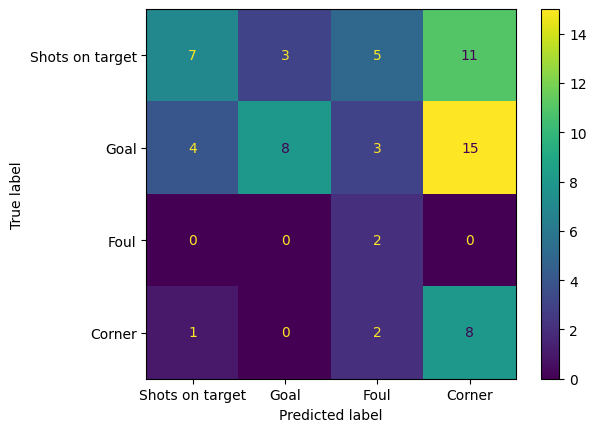

Matriz de Confusão:
[[ 7  3  5 11]
 [ 4  8  3 15]
 [ 0  0  2  0]
 [ 1  0  2  8]]

Percentagem de acerto: 36.23%


In [9]:
#print(dados)

#Se quisermos salvar as colunas no dataframe
#dados.to_csv(caminho_arquivo, index=False)

# Construir a matriz de confusão
confusion_matrix = metrics.confusion_matrix(dados['label'], dados['categoria'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=candidate_labels)
cm_display.plot()
plt.show()

# Calcular as percentagens de acerto
total_predicoes = np.sum(confusion_matrix)
predicoes_corretas = np.trace(confusion_matrix)
percentagem_acerto = predicoes_corretas / total_predicoes * 100

# Exibir a matriz de confusão e a percentagem de acerto
print("Matriz de Confusão:")
print(confusion_matrix)
print("\nPercentagem de acerto: {:.2f}%".format(percentagem_acerto))